In [1]:
!pip install --upgrade pip
# 各ライブラリインストール
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

# 環境変数設定
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

# findsparkで環境設定
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

     |████████████████████████████████| 1.4MB 4.5MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1


In [2]:
!wget https://github.com/IBM/coursera/blob/master/coursera_ds/washing.parquet?raw=true
!mv washing.parquet?raw=true washing.parquet

--2020-03-30 07:50:04--  https://github.com/IBM/coursera/blob/master/coursera_ds/washing.parquet?raw=true
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/IBM/skillsnetwork/blob/master/coursera_ds/washing.parquet?raw=true [following]
--2020-03-30 07:50:04--  https://github.com/IBM/skillsnetwork/blob/master/coursera_ds/washing.parquet?raw=true
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/IBM/skillsnetwork/raw/master/coursera_ds/washing.parquet [following]
--2020-03-30 07:50:04--  https://github.com/IBM/skillsnetwork/raw/master/coursera_ds/washing.parquet
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/IBM/skillsnetwork/master/coursera_ds/washing.parquet

In [3]:
df = spark.read.parquet('washing.parquet')
df.createOrReplaceTempView('washing')
df.show()

+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|                 _id|                _rev|count|flowrate|fluidlevel|frequency|hardness|speed|temperature|           ts|voltage|
+--------------------+--------------------+-----+--------+----------+---------+--------+-----+-----------+-------------+-------+
|0d86485d0f88d1f9d...|1-57940679fb8a713...|    4|      11|acceptable|     null|      77| null|        100|1547808723923|   null|
|0d86485d0f88d1f9d...|1-15ff3a0b304d789...|    2|    null|      null|     null|    null| 1046|       null|1547808729917|   null|
|0d86485d0f88d1f9d...|1-97c2742b68c7b07...|    4|    null|      null|       71|    null| null|       null|1547808731918|    236|
|0d86485d0f88d1f9d...|1-eefb903dbe45746...|   19|      11|acceptable|     null|      75| null|         86|1547808738999|   null|
|0d86485d0f88d1f9d...|1-5f68b4c72813c25...|    7|    null|      null|       75|    null| null|   

In [0]:
result = spark.sql("""
SELECT*from(
    SELECT
    min(temperature) over w as min_temperature,
    max(temperature) over w as max_temperature,
    min(voltage) over w as min_voltage,
    max(voltage) over w as max_voltage,
    min(flowrate) over w as min_flowrate,
    max(flowrate) over w as max_flowrate,
    min(frequency) over w as min_frequency,
    max(frequency) over w as max_frequency,
    min(hardness) over w as min_hardness,
    max(hardness) over w as max_hardness,
    min(speed) over w as min_speed,
    max(speed) over w as max_speed
    FROM washing
    WINDOW w AS (ORDER BY ts ROWS BETWEEN CURRENT ROW AND 10 FOLLOWING)
)
WHERE min_temperature is not null
AND max_temperature is not null
AND min_voltage is not null
AND max_voltage is not null
AND min_flowrate is not null
AND max_flowrate is not null
AND min_frequency is not null
AND max_frequency is not null
AND min_hardness is not null
AND max_hardness is not null
AND min_speed is not null
AND max_speed is not null
""")

In [6]:
df.count()-result.count()

7

In [0]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [0]:
assembler = VectorAssembler(inputCols=result.columns, outputCol="features")

In [0]:
features = assembler.transform(result)

In [11]:
features.rdd.map(lambda r:r.features).take(10)

[DenseVector([81.0, 100.0, 221.0, 223.0, 11.0, 11.0, 68.0, 76.0, 71.0, 78.0, 1033.0, 1033.0]),
 DenseVector([81.0, 100.0, 221.0, 223.0, 11.0, 11.0, 68.0, 76.0, 72.0, 78.0, 1033.0, 1033.0]),
 DenseVector([81.0, 100.0, 221.0, 223.0, 11.0, 11.0, 68.0, 76.0, 72.0, 80.0, 1033.0, 1033.0]),
 DenseVector([81.0, 100.0, 222.0, 223.0, 11.0, 11.0, 68.0, 74.0, 72.0, 80.0, 1033.0, 1046.0]),
 DenseVector([81.0, 100.0, 222.0, 223.0, 11.0, 11.0, 68.0, 74.0, 73.0, 80.0, 1033.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 223.0, 11.0, 11.0, 68.0, 74.0, 73.0, 80.0, 1033.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 236.0, 11.0, 11.0, 68.0, 74.0, 73.0, 80.0, 1046.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 236.0, 11.0, 11.0, 68.0, 74.0, 73.0, 80.0, 1046.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 236.0, 11.0, 11.0, 71.0, 74.0, 73.0, 80.0, 1046.0, 1046.0]),
 DenseVector([80.0, 94.0, 222.0, 236.0, 11.0, 11.0, 71.0, 74.0, 73.0, 80.0, 1046.0, 1046.0])]

In [0]:
pca = PCA(k=3, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(features)

In [14]:
result_pca = model.transform(features).select("pcaFeatures")
result_pca.show(truncate=False)

+-----------------------------------------------------------+
|pcaFeatures                                                |
+-----------------------------------------------------------+
|[1459.9789705814187,-18.745237781780922,70.78430794796873] |
|[1459.995481828676,-19.11343146165273,70.72738871425986]   |
|[1460.0895843561282,-20.969471062922928,70.75630600322052] |
|[1469.6993929419532,-20.403124647615513,62.013569674880955]|
|[1469.7159041892107,-20.771318327487293,61.95665044117209] |
|[1469.7128317338704,-20.790751117222456,61.896106678330966]|
|[1478.3530264572928,-20.294557029728722,71.67550104809607] |
|[1478.3530264572928,-20.294557029728722,71.67550104809607] |
|[1478.3686036138165,-20.260626897636314,71.63355353606426] |
|[1478.3686036138165,-20.260626897636314,71.63355353606426] |
|[1483.5412027684088,-20.006222577501354,66.82710394284209] |
|[1483.5171090223353,-20.867020421583753,66.86707301954084] |
|[1483.4224268542928,-19.87574823665505,66.93027077913985]  |
|[1483.4

In [15]:
result_pca.count()

2051

In [0]:
rdd=result_pca.rdd.sample(False,0.8)

In [0]:
x = rdd.map(lambda a : a.pcaFeatures).map(lambda a: a[0]).collect()

In [0]:
y = rdd.map(lambda a : a.pcaFeatures).map(lambda a: a[1]).collect()

In [0]:
z = rdd.map(lambda a : a.pcaFeatures).map(lambda a: a[2]).collect()

ERROR! Session/line number was not unique in database. History logging moved to new session 59


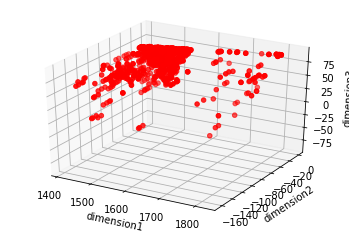

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x,y,z, c='r', marker='o')

ax.set_xlabel('dimension1')
ax.set_ylabel('dimension2')
ax.set_zlabel('dimension3')

plt.show()